In [298]:
import os
import csv
import re
import matplotlib.pyplot as plt
import numpy as np

from pybeerxml.parser import Parser

In [299]:
# Create a yeast name-to-id system
from yeast_db import build_yeast_dicts
yeast_name_to_id, brand_to_ids, id_to_yeast_names = build_yeast_dicts()

In [ ]:
ogs = []
fgs = []
yeasts = set()
malts = set()

parser = Parser()
#dir_count = 0
valid_file_count = 0

def clean_replace(s, target):
    return s.replace(target, '').replace("  ", " ").strip()

for dirpath, dirnames, files in os.walk('./data/_matched'):
    #if dir_count < 100: 
    #    dir_count += 1
    #    continue
    #dir_count += 1
    
    for file_name in files:
        file_path = str(os.path.join(dirpath, file_name))
        try:
            recipes = parser.parse(file_path)
        except:
            print("Erroneous file found, removing: " + file_path)
            os.remove(file_path)
            continue
        
        recipe_valid = False
        for recipe in recipes:
            ogs.append(recipe.og)
            fgs.append(recipe.fg)

            for y in recipe.yeasts:

                if not isinstance(y.name, str):
                    # Try turning the name into a code (likely a wyeast strain)...
                    yeast_name = str(int(y.name))
                else:
                    yeast_name = y.name.lower()
                    # Some basic clean-up to start...
                    if "conan" in yeast_name: yeast_name = "vermont ale"
                    elif "super high gravity" in yeast_name or "wlp 099" in yeast_name: yeast_name = "super high gravity ale"
                    elif "super yeast" in yeast_name: yeast_name = "san diego super"
                    elif "chico" in yeast_name: yeast_name = "chico ale"
                    elif "orval" in yeast_name: yeast_name = "brettanomyces bruxellensis"
                    elif "duvel" in yeast_name: yeast_name = "belgian golden ale"
                    elif "dupont" in yeast_name: yeast_name = "french saison ale"
                    else:
                        # Clean up any spelling mistakes, ordering
                        yeast_name = yeast_name.replace("kรถlsch","kolsch").replace("kรถlsh","kolsch").replace("kölsh","kolsch")
                        yeast_name = yeast_name.replace("monastery","monastary").replace("monestary","monastary")
                        yeast_name = yeast_name.replace("california v ale", "california ale v")
                        yeast_name = yeast_name.replace("mã©lange","melange").replace("brettâ€™","brett") \
                            .replace("cã´te","cote").replace("munuch","munich").replace("lellemand","lallemand") \
                            .replace("champagene", "champagne").replace("vemont","vermont")

                if yeast_name not in yeast_name_to_id:
                    # First attempt: Try to find a yeast code to match
                    s = re.search(r"(inis\-|wlp|us\-|([kwst]|oyl|bry)\-|[mg]|\d+/)\s?\-?(\d+(/\d+)?)", yeast_name, flags=re.IGNORECASE)
                    if s != None and len(s.group()) > 0:
                        # We have a potential yeast product id...
                        product_id = s.group().replace("--","-").replace(" ","")
                        if product_id not in yeast_name_to_id:
                            pass
                            #print(f"Product id {product_id} not found for {yeast_name}, file: {file_path}")
                        else:
                            continue

                    # Try removing the word "yeast" (and watch out for any double spaces that may ensue)
                    if clean_replace(yeast_name, "yeast") in yeast_name_to_id:
                        continue
                    # Try replacing "yeast" with "ale" or "lager"
                    if yeast_name.replace("yeast", "ale") in yeast_name_to_id or yeast_name.replace("yeast", "lager") in yeast_name_to_id:
                        continue
                    # Try adding "ale" or "blend" or "lager" to the end
                    if yeast_name+" ale" in yeast_name_to_id or yeast_name+" lager" in yeast_name_to_id or yeast_name+" blend" in yeast_name_to_id:
                        continue

                    # Check for a wyeast code (4 digit code)
                    s = re.search(r"(\d{4})(\D+|$)", yeast_name, flags=re.IGNORECASE)
                    if s != None and len(s.group(1)) > 0:
                        product_id = s.group(1)
                        if product_id in yeast_name_to_id:
                            continue

                    # Try to match the brand name first and then try to figure out
                    # which yeast we're dealing with within that brand 
                    for brand_name, ids in brand_to_ids.items():
                        s = re.search(brand_name, yeast_name, flags=re.IGNORECASE)
                        if s != None and len(s.group()) > 0:
                            # Find the best possible match
                            best_match_count = 0
                            best_match_id = -1
                            for id in ids:
                                count = 0
                                potential_yeast_names = id_to_yeast_names[id]
                                for name in potential_yeast_names:
                                    s = re.search(name, yeast_name, flags=re.IGNORECASE)
                                    if s != None: count += 1
                                if count > best_match_count:
                                    best_match_count = count
                                    best_match_id = id
                            if best_match_id == -1:
                                # Just choose the first id...
                                assert len(ids) > 0
                                best_match_id = ids[0]
                                yeast_name = id_to_yeast_names[best_match_id][0]
                            else:
                                pass
                                #print(f"Found a brand-based match for '{yeast_name}', with brand '{brand_name}', and names: {id_to_yeast_names[best_match_id]}")

                            break


                    # Last attempt - try to match any of the ids directly with the yeast name string
                    found = False
                    best_len = 0
                    best_name = ""
                    for dict_name in yeast_name_to_id:
                        name_opts = f"({dict_name}|{clean_replace(dict_name, 'ale')}|{clean_replace(dict_name,'lager')})"
                        s = re.search(name_opts, yeast_name)
                        if s != None and len(s.group()) > 0:
                            group_len = len(s.group())
                            if best_len < group_len:
                                best_len = group_len
                                best_name = dict_name

                    if best_len == 0:
                        if yeast_name == '- -' or yeast_name == 'default - - -' or '?' in yeast_name or yeast_name == "deleteme":
                            print(f"Deleting file with empty/unknown (e.g., '- -') yeast: {file_path}")
                            import shutil
                            shutil.copy(file_path, "./data/_not_matched")
                        else:
                            print(f"No matches for '{yeast_name}', file: {file_path}, deleting...")
                            os.remove(file_path)
                        break
                    else:
                        recipe_valid = True
                        #print(f"Matched '{yeast_name}' with '{best_name}', file: {file_path}")
        if recipe_valid:
            valid_file_count += 1
            
        #for m in recipe.fermentables:
        #    if m.type == None:
        #        print(f"Malt type none found in file {file_path}")
        #malts.update([m.name for m in recipe.fermentables])
print(f"Valid files found: {valid_file_count}")

In [308]:
# Create a fermentable name-to-id system
# NOTE: https://www.wildabouthops.nz/malt_substitutes.html
fermentable_name_to_id  = {}
id_to_fermentable_names = {}
with open("./data/_db/fermentables.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=";")
    for i,row in enumerate(csv_reader):
        if i == 0: continue
        names = []
        fermentable_name = row[0].lower().strip()
        fermentable_name_to_id[fermentable_name] = i
        names.append(fermentable_name)
        
        for alt_name in row[3].split(",") + row[4].split(","):
            alt_name = alt_name.strip()
            if len(alt_name) > 0:
                alt_name = alt_name.lower()
                fermentable_name_to_id[alt_name] = i
                names.append(alt_name)
                
        assert len(names) > 0
        id_to_fermentable_names[i] = names

In [309]:
fermentable_name_to_id

{'basic barley malt': 1,
 'brewers malt 2-row': 1,
 '2 row': 1,
 'standard 2-row': 1,
 'base malt': 1,
 '2-row': 1,
 'two-row': 1,
 'barley malt': 1,
 'standard malt': 1,
 'basic malt': 1,
 'two row': 1,
 '2row': 1,
 'best heidelberg malt': 1,
 'heidelberg': 1,
 'bayer': 1,
 'american devil ipa': 1,
 'enzyme malt': 2,
 '6-row': 2,
 'six-row': 2,
 '6 row': 2,
 'six row': 2,
 'distillers malt': 2,
 "distiller's malt": 25,
 'distilling malt': 2,
 'munich malt': 3,
 'munich': 3,
 'münchner malz': 3,
 'bonlander munich': 3,
 'bonlander': 3,
 'munich malt 20l': 3,
 'munchener': 3,
 'monachijski': 3,
 'münchenermout': 3,
 'munich light malt': 4,
 'munich malt i': 4,
 'munich light': 4,
 'münchner malz hell': 4,
 'light munich': 4,
 'munich malt light': 4,
 'münchner malz i': 4,
 'münchner i': 4,
 'munich type i': 4,
 'munich i': 4,
 'munich - light': 4,
 'muenchner i': 4,
 'breiss 21l': 4,
 'munich dark malt': 5,
 'munich malt ii': 5,
 'munich dark': 5,
 'münchner malz dunkel': 5,
 'dark muni

In [ ]:
dir_count = 0
dir_min = 55
dir_max = 60

for dirpath, dirnames, files in os.walk('./data/_matched'):
    dir_count += 1
    if dir_count < dir_min: 
        continue
    elif dir_count > dir_max:
        break
    
    for file_name in files:
        file_path = str(os.path.join(dirpath, file_name))
        recipes = parser.parse(file_path)
        
        for recipe in recipes:
            for fermentable in recipe.fermentables:
                
                f_name = str(fermentable.name).lower()
                init_name = f_name
                
                # Start with some basic clean-up
                f_name = f_name.replace("carafaâ","carafa").replace("®","").replace("速","").replace("marris","maris") \
                    .replace("roasted oats","malted oats").replace("mdâ„¢","").replace("torrefied","torrified").replace("specl","special") \
                    .replace("carafaz", "carafa").replace("kรถlsch", "kolsch").replace("©","").replace("ch창teau", "chateau").replace("aรงucar","")
                f_name = re.sub(r"[\'\"](w|b)[\'\"]", r"\1", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\brosted\b", "roasted", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\bcarmel\b", "caramel", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\bsirup\b", "syrup", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\,?\s*steel\s*cut\s*\(?pinhead\s*oats\)?", "", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"(md)?™","",f_name,flags=re.IGNORECASE)
                f_name = re.sub(r"(.+)\s*\,\s*(flaked|malted|cooked)\s*", r"\1 \2", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\s*\((us|de|uk|nz|be|pl|english|british|german|belgian|patent|american)\)\s*", " ", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\s*(english|german)\s*", "", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"(cara\s+|crystal\s*/\s*caramel|caramel\s*/\s*crystal|caramel|crystal)(\s+malts?\s+\-?)?","caramel/crystal", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\s*\(?(bob'?s\s*mills|homemade|malting|cal\s*rose|cargill|((green|black|gold)\s?)?swaen|munton'?s?|warminster|biscoff|patagonia|global malt|thomas\s*fawcett|crisp|best\s*(malz|maltz)|simpsons?|valley\s*(malt)?|briess|bairds|gladfields?|château|chateau|castle|dingemans|brewers\s+malt|rahr|organic|dehusked)\)?\s*\-*\s*", " ", f_name, flags=re.IGNORECASE)
                f_name = re.sub(r"\(?\d+\s+(ebc|lovibond)\)?\:?", "", f_name, flags=re.IGNORECASE)
                
                f_name = f_name.replace(",","").strip()
                
                if f_name in fermentable_name_to_id:
                    continue
                    
                # Try adding "malt" to the end
                if f_name+" malt" in fermentable_name_to_id:
                    continue
                # Try removing "malt" from the end
                if re.sub(r"\s*malt", "", f_name, flags=re.IGNORECASE) in fermentable_name_to_id:
                    continue
                
                best_len_s1 = 0
                best_id_s1  = -1
                best_len_s2 = 0
                best_id_s2  = -1
                for dict_name, dict_id in fermentable_name_to_id.items():
                    name_opts = "(" + dict_name + ")"
                    s1 = re.search(name_opts, f_name)
                    if s1 != None and len(s1.group()) > 0:
                        group_len = len(s1.group())
                        if best_len_s1 < group_len:
                            best_len_s1 = group_len
                            best_id_s1  = dict_id
                    else:
                        s2 = re.search(name_opts, init_name)
                        if s2 != None and len(s2.group()) > 0:
                            group_len = len(s2.group())
                            if best_len_s2 < group_len:
                                best_len_s2 = group_len
                                best_id_s2  = dict_id

                if best_len_s1 == 0 and best_len_s2 == 0:
                    print(f"Name not found: Modified name: '{f_name}', Original name: '{init_name}' in file: {file_path}") 
        

Name not found: Modified name: 'north-west high colour', Original name: 'north-west high colour' in file: ./data/_matched/7/bt_39293.xml
Name not found: Modified name: 'karmelowy viking malt', Original name: 'karmelowy viking malt' in file: ./data/_matched/7/bt_8396.xml
Name not found: Modified name: 'waffle cone', Original name: 'waffle cone' in file: ./data/_matched/7/bt_85356.xml
Name not found: Modified name: '-sour', Original name: 'german-sour' in file: ./data/_matched/7/319872.xml
Name not found: Modified name: 'rock candy', Original name: 'rock candy' in file: ./data/_matched/7/bt_226140.xml
Name not found: Modified name: 'raw durum', Original name: 'raw durum' in file: ./data/_matched/7/509384.xml
Name not found: Modified name: 'negra', Original name: 'negra' in file: ./data/_matched/7/591122.xml
Name not found: Modified name: 'vit syrup', Original name: 'vit syrup' in file: ./data/_matched/7/bt_118014.xml
Name not found: Modified name: 'gambrinus', Original name: 'gambrinus' 

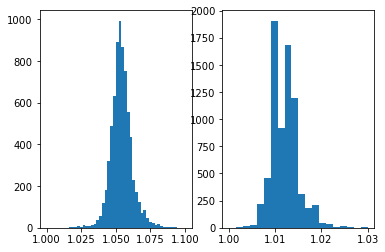

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(ogs, bins=50, range=(1.0, 1.1));
ax2.hist(fgs, bins=20, range=(1.0, 1.03));

In [86]:
ogs = np.array(ogs)
fgs = np.array(fgs)
print(ogs.mean(), ogs.std())
print(fgs.mean(), fgs.std())

1.053665150888797 0.009690755932266558
1.0119204905608377 0.0032176378292414834


In [88]:
n_ogs = (ogs - ogs.mean()) / ogs.std()
n_fgs = (fgs - fgs.mean()) / fgs.std()
print(n_ogs.mean(), n_ogs.std())
print(n_fgs.mean(), n_fgs.std())

-7.0745852793642054e-15 1.0
3.3299653359791936e-14 1.0
